In [3]:
import anvil.server

In [4]:
anvil.server.connect('6FALVTHQFSIWK7CKU3FVYF5F-K3STKZUOHDUK6CM3')

Connecting to wss://anvil.works/uplink
Anvil websocket open
Authenticated OK


In [5]:
@anvil.server.callable
def boomer

SyntaxError: unexpected EOF while parsing (<ipython-input-5-f3784f8bd59c>, line 1)

In [ ]:
# Set your Sentinel Hub instance ID either here or 
# in command line with sentinelhub.config --instance_id <your instance id>
INSTANCE_ID = 'c3800994-a5d2-4cf1-8d96-b20d6e9d16de'

### Define the necessary imports

In [ ]:
# set the autoreload and the inline plotting for matplotlib
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# download
import requests
import json

# data manipulation
import numpy as np
import numpy.ma as ma

# geometry manipulation
import geopandas as gpd
import shapely.geometry
import shapely.wkt
from shapely.geometry import Point, MultiPolygon, Polygon

# image manipulation
import skimage.feature
import skimage.filters
import skimage.morphology
import rasterio




# Sentinel Hub
#from sentinelhub import BBox, CRS
from sentinelhub import *

#from pyproj import *
#CRS("ESRI:54009")

# eo-learn related
from eolearn.core import EOTask, LinearWorkflow, FeatureType
from eolearn.io import S2L1CWCSInput
from eolearn.mask import AddCloudMaskTask, AddValidDataMaskTask, get_s2_pixel_cloud_detector
from eolearn.geometry import VectorToRaster

# plotting
import matplotlib
import matplotlib.patheffects
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

rasterio.crs.CRS.from_string("epsg:28992")
rasterio.crs.CRS.from_epsg(28992)

In [ ]:
WATERBODY_ID = 0

In [ ]:
def get_nominal_geometry(waterbody_id):
    """ A function for obtaining the nominal water geometry from the water observatory API
    """
    with open('Reserviour.json') as f:
        data = json.load(f)

    #wb_url = f'https://water.blue-dot-observatory.com/api/waterbodies/{waterbody_id}/index.html'
    #wb_data = requests.get(wb_url).json()
    op2= shapely.geometry.shape(data['features'][waterbody_id]['geometry'])
    return op2
    #return shapely.geometry.shape(wb_data['nominal_outline']['geometry'])

def plot_geometry(geom, ax=None, **kwargs):
    """ An utility function for plotting the geometry 
    """
    if geom is None or geom.exterior is None:
        return

    x,y = geom.exterior.xy
    if ax is None:
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        
    ax.plot(x, y, **kwargs)

In [ ]:
nominal_geometry = get_nominal_geometry(WATERBODY_ID)

plot_geometry(nominal_geometry)

In [ ]:
wb_bbox = BBox(nominal_geometry.bounds, crs=CRS.WGS84).buffer(0.2)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
plot_geometry(wb_bbox.geometry, ax)
plot_geometry(nominal_geometry, ax)

In [ ]:
class WaterDetectionTask(EOTask):
    """ A task for water mask and water level detection
    """
    def __init__(self, ndwi_feature, vector_result_feature, scalar_result_feature, nominal_geometry, *,
                 simplify=True, canny_sigma=4, canny_threshold=0.3, dilation_size=4):
        """
        :param ndwi_feature: Input feature of EOPatch containing NDWI values
        :type ndwi_feature: (FeatureType, str)
        :param vector_result_feature: A resulting vector feature containing waterbody geometries
        :type: vector_result_feature: (FeatureType, str)
        :param scalar_result_feature: A resulting scalar feature containing ratios between calculated area of detected
            waterbody and area of nominal waterbody
        :type scalar_result_feature: (FeatureType, str)
        :param nominal_geometry: A geometry of a waterbody
        :type nominal_geometry: shapely.geometry.Polygon or shapely.geometry.MultiPolygon
        :param simplify: A flag specifying if resulting geometry should be simplified
        :type simplify: bool
        :param canny_sigma: `sigma` parameter of `skimage.feature.canny` function
        :type canny_sigma: float
        :param canny_threshold: `high_threshold` parameter of `skimage.feature.canny` function
        :type canny_threshold: float
        :param dilation_size: Size of dilation in pixels used by `skimage.morphology.binary_dilation`
        :type dilation_size: int
        """
        self.ndwi_feature = ndwi_feature
        self.vector_result_feature = vector_result_feature
        self.scalar_result_feature = scalar_result_feature
        self.nominal_geometry = nominal_geometry

        self.simplify = simplify
        self.canny_sigma = canny_sigma
        self.canny_threshold = canny_threshold
        self.dilation_disk = skimage.morphology.disk(dilation_size)

    def _get_water_level(self, ndwi, bbox):
        """ Run water detection algorithm for an NDWI image
        """
        water_mask, water_status = self._get_water_mask_from_s2(ndwi)
        measured_water_extent = self._get_water_extent(water_mask, bbox)

        return {
            'WATER_LEVEL': measured_water_extent.area / self.nominal_geometry.area,
            'STATUS': water_status,
            'geometry': measured_water_extent
        }

    def _get_water_mask_from_s2(self, ndwi):
        """ Make water detection on input NDWI single band image
        """
        # default threshold (no water detected)
        otsu_thr = 1.0
        status = 0

        # transform NDWI values to [0,1]
        ndwi_std = (ndwi - np.min(ndwi)) / np.ptp(ndwi)

        if len(np.unique(ndwi)) > 1:
            edges = skimage.feature.canny(ndwi_std, sigma=self.canny_sigma, high_threshold=self.canny_threshold)
            edges = skimage.morphology.binary_dilation(edges, self.dilation_disk)
            ndwi_masked = ma.masked_array(ndwi, mask=np.logical_not(edges))

            if len(np.unique(ndwi_masked.data[~ndwi_masked.mask])) > 1:
                # threshold determined using dilated canny edge + otsu
                otsu_thr = skimage.filters.threshold_otsu(ndwi_masked.data[~ndwi_masked.mask])
                status = 1

                # if majority of pixels above threshold have negative NDWI values
                # change the threshold to 0.0
                fraction = np.count_nonzero(ndwi > 0) / np.count_nonzero(ndwi > otsu_thr)
                if fraction < 0.9:
                    otsu_thr = 0.0
                    status = 3
            else:
                # theshold determined with otsu on entire image
                otsu_thr = skimage.filters.threshold_otsu(ndwi)
                status = 2

                # if majority of pixels above threshold have negative NDWI values
                # change the threshold to 0.0
                fraction = np.count_nonzero(ndwi > 0) / np.count_nonzero(ndwi > otsu_thr)
                if fraction < 0.9:
                    otsu_thr = 0.0
                    status = 4

        return (ndwi > otsu_thr).astype(np.uint8), status

    def _get_water_extent(self, water_mask, bbox):
        """
        Returns the polygon of measured water extent.
        """
        src_transform = rasterio.transform.from_bounds(*bbox.lower_left, *bbox.upper_right,
                                                       width=water_mask.shape[1], height=water_mask.shape[0])

        # do vectorization of raster mask
        results = [{'properties': {'raster_val': value}, 'geometry': geo}
                   for geo, value in rasterio.features.shapes(water_mask, transform=src_transform) if value == 1]

        if len(results) == 0:
            return Point(0, 0), 0, 0

        polygonized_results = gpd.GeoDataFrame.from_features(results)
        polygonized_results.geometry = polygonized_results.geometry.buffer(0)
        polygonized_results = polygonized_results[polygonized_results.geometry.is_valid]
        polygonized_results = polygonized_results[polygonized_results.intersects(self.nominal_geometry)]

        measured_water_extent = polygonized_results.cascaded_union
        measured_water_extent = measured_water_extent.buffer(0)

        if self.simplify:
            measured_water_extent = self._simplify_geometry(measured_water_extent, 0.0, 0.0001,
                                                            min(100000, len(self.nominal_geometry.wkt) * 100))

        return measured_water_extent

    @staticmethod
    def _simplify_geometry(geometry, simpl_fact=0.0, simpl_step=0.0001, threshold=20000):
        """
        Simplifies a geometry by reducing the number of vertices.
        """
        while len(geometry.wkt) > threshold:
            geometry = geometry.simplify(simpl_fact, preserve_topology=False)
            simpl_fact += simpl_step

        return geometry

    def execute(self, eopatch):
        """ The execute method
        """
        ndwi_data = eopatch[self.ndwi_feature]

        results = (self._get_water_level(ndwi_data[idx, ..., 0], eopatch.bbox) for idx in range(ndwi_data.shape[0]))

        result_dict = {}
        for wb_result in results:
            for name, value in wb_result.items():
                result_dict[name] = result_dict.get(name, [])
                result_dict[name].append(value)

        gdf = gpd.GeoDataFrame(result_dict, crs={'init': eopatch.bbox.crs.ogc_string()})
        gdf['TIMESTAMP'] = eopatch.timestamp

        eopatch[self.vector_result_feature] = gdf
        eopatch[self.scalar_result_feature] = np.array(result_dict['WATER_LEVEL'])[..., np.newaxis]

        return eopatch

### Definitions of some custom tasks that will be used in the workflow

In [ ]:
class ValidDataPredicate:
    """ An operator to return valid data as an union of pixels with non-zero values and pixels that contain 
    no clouds
    """
    def __call__(self, eopatch):     
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))


class AddValidDataCoverage(EOTask):
    """ A task that calculates and adds the valid coverage scalar to the EOPatch
    """
    @staticmethod
    def get_coverage(data):
        """ Calculate fraction of pixels with non-zero values
        """
        return 1.0 - np.count_nonzero(data)/np.size(data)
    
    def execute(self, eopatch):

        valid_mask = eopatch.mask['VALID_DATA']
        new_shape = valid_mask.shape[0], valid_mask.shape[1] * valid_mask.shape[2]
        
        coverage = np.apply_along_axis(self.get_coverage, 1, np.reshape(valid_mask, new_shape))
        
        eopatch.scalar['COVERAGE'] = coverage[:, np.newaxis]
        return eopatch

### Initializations of EOTasks

In [ ]:
# A task for downloading RGB bands
# `TRUE-COLOR-S2-L1C` is the name of the layer defined in the Sentinel Hub configurator.
# the arguments are the resolution of the image, max cloud coverage of the whole Satellite tile, 
# and the instance ID for your Sentinel Hub account
input_task = S2L1CWCSInput(layer='TRUE-COLOR-S2-L1C', 
                           resx='60m', resy='60m', maxcc=0.5, 
                           instance_id=INSTANCE_ID)

# A task for downloading the NDWI band combination
# other parameters are copied from the previous task
add_ndwi = S2L1CWCSInput('NDWI', instance_id=INSTANCE_ID)

# A task for cloud detection
# cloud probability map (CLP) and cloud mask (CLM) are calculated at 160 m resolution in order to speed up the process
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
cloud_det = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='160m', cm_size_x='160m', 
                             cmask_feature='CLM', cprobs_feature='CLP', instance_id=INSTANCE_ID)

# A task for adding a raster mask of the nominal water extent (NOMINAL_WATER) 
# raster shape is provided by an existing feature inside of the EOPatch
add_nominal_water = VectorToRaster(gpd.GeoDataFrame(crs={'init': 'epsg:4326'}, geometry=[nominal_geometry]),
                                   (FeatureType.MASK_TIMELESS, 'NOMINAL_WATER'),
                                   values=1, 
                                   raster_shape=(FeatureType.MASK, 'IS_DATA'), 
                                   raster_dtype=np.uint8)

# A task for adding valid data mask to the EOPatch (mask type)
add_valmask = AddValidDataMaskTask(predicate=ValidDataPredicate())

# A task for adding valid data coverage to the EOPatch (scalar type)
add_coverage = AddValidDataCoverage()
print(add_coverage.__dict__)
# A task for water detection
water_det = WaterDetectionTask((FeatureType.DATA, 'NDWI'),
                               (FeatureType.VECTOR, 'WATER_OUTLINE'),
                               (FeatureType.SCALAR, 'WATER_LEVEL'),
                               nominal_geometry)
print(water_det.__dict__)

### Define and run the workflow

In [ ]:
workflow = LinearWorkflow(
    input_task, 
    add_ndwi, 
    cloud_det, 
    add_nominal_water, 
    add_valmask, 
    add_coverage,
    water_det
)

workflow.dependency_graph()

Let's run the workflow. It will take a few minutes.

In [7]:
%%time

# time interval definition
TIME_INTERVAL = '2019-12-12', '2020-01-01'

# execute the workflow
result = workflow.execute({
    input_task: {
        'bbox': wb_bbox,
        'time_interval': TIME_INTERVAL
    }
})

NameError: name 'workflow' is not defined

### Structure of the `EOPatch`

In [8]:
# result is in the form of a dictionary
eopatch = result.eopatch()
eopatch

NameError: name 'result' is not defined

Anvil websocket closed (code 1006, reason=Going away)


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/machine/myenv/lib/python3.7/site-packages/anvil/server.py", line 286, in call
    return _do_call(args, kwargs, fn_name=fn_name)
  File "/home/machine/myenv/lib/python3.7/site-packages/anvil/server.py", line 278, in _do_call
    return _threaded_server.do_call(args, kwargs, fn_name=fn_name, live_object=live_object)
  File "/home/machine/myenv/lib/python3.7/site-packages/anvil/_threaded_server.py", line 393, in do_call
    raise _server._deserialise_exception(r["error"])
anvil._server.AnvilWrappedError: 'Connection to Anvil Uplink server lost'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/machine/myenv/lib/python3.7/site-packages/anvil/server.py", l

Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnec

Let's now visualize the first few true-color images of the selected waterbody in the given time series. We see below that some images contain clouds, which causes problems in proper water level detection.

### Plot the NDWI to see how the water detector traces the waterbody outline

IndexError: index 2 is out of bounds for axis 0 with size 2

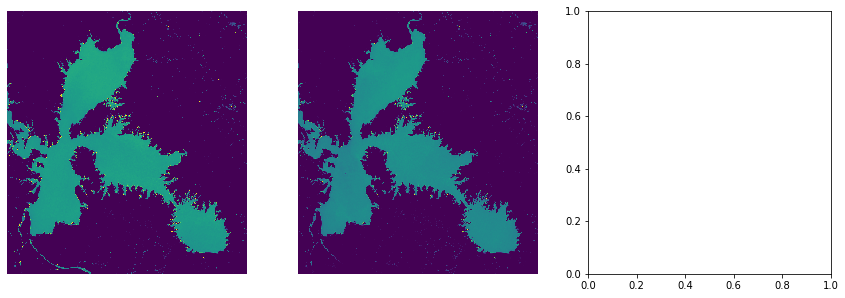

In [13]:
# get aspect ratio of image for better plotting
image_ratio = eopatch.mask_timeless['NOMINAL_WATER'].shape[0] / eopatch.mask_timeless['NOMINAL_WATER'].shape[1]

# plot the NDWI at different dates
fig = plt.figure(figsize=(20, 15 * image_ratio))

for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    ax.imshow(eopatch.data['NDWI'][i].squeeze(), vmin=0, vmax=1)
    ax.axis('off')
    
plt.tight_layout()

### Plot true-color images with the detected water outlines

In [14]:
def plot_waterbody(image, nominal_geometry, bbox, water_extent,
                   color_nominal='white', color_current='xkcd:lime', ax=None, lw=2):
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

    ax.imshow(image, extent=[bbox.min_x, bbox.max_x, bbox.min_y, bbox.max_y])

    draw_geometry(ax, nominal_geometry, color_nominal, lw=lw)
    draw_geometry(ax, water_extent, color_current, lw=lw)


def draw_geometry(ax, geometry, color, lw=2):
    if isinstance(geometry, Polygon):
        draw_polygon(ax, geometry, color, lw=lw)
    elif isinstance(geometry, MultiPolygon):
        for polygon in geometry:
            draw_polygon(ax, polygon, color, lw=lw)


def draw_polygon(ax, polygon, color, lw=2):
    if polygon is None or polygon.exterior is None:
        return None

    x, y = polygon.exterior.coords.xy
    xy = np.moveaxis(np.array([x, y]), 0, -1)
    patch = ax.add_patch(matplotlib.patches.Polygon(xy, closed=True, edgecolor=color, fill=False, lw=lw))
    
    draw_outline(patch, 4)


def draw_outline(o, lw):
    o.set_path_effects([matplotlib.patheffects.Stroke(linewidth=lw, foreground='black'),
                        matplotlib.patheffects.Normal()])

IndexError: index 2 is out of bounds for axis 0 with size 2

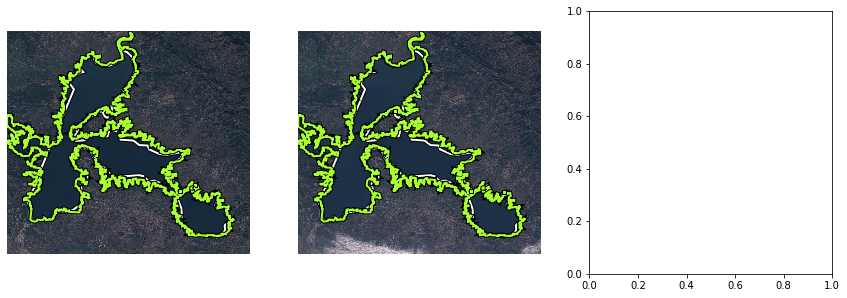

In [15]:
image_ratio = eopatch.data['TRUE-COLOR-S2-L1C'][0].shape[0] / eopatch.data['TRUE-COLOR-S2-L1C'][0].shape[1]

fig = plt.figure(figsize=(20, 15 * image_ratio))

for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plot_waterbody(eopatch.data['TRUE-COLOR-S2-L1C'][i], nominal_geometry,
                   wb_bbox, eopatch.vector['WATER_OUTLINE']['geometry'][i], ax=ax)
    ax.axis('off')
    
plt.tight_layout(pad=0)

### Plotting the detected water levels

In [16]:
# This is just to suppress a plotting warning
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

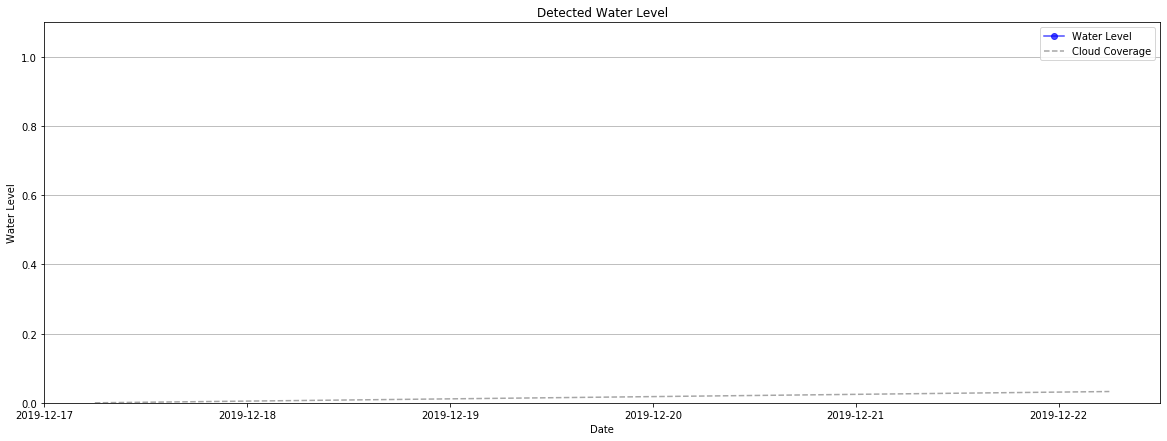

In [17]:
def plot_water_levels(eopatch, max_coverage=1.0):
    fig, ax = plt.subplots(figsize=(20, 7))

    dates = np.array(eopatch.timestamp)
    ax.plot(dates[eopatch.scalar['COVERAGE'][...,0] < max_coverage],
            eopatch.scalar['WATER_LEVEL'][eopatch.scalar['COVERAGE'][...,0] < max_coverage],
            'bo-', alpha=0.7, label='Water Level')
    ax.plot(dates[eopatch.scalar['COVERAGE'][...,0] < max_coverage],
            eopatch.scalar['COVERAGE'][eopatch.scalar['COVERAGE'][...,0] < max_coverage],
            '--', color='gray', alpha=0.7, label='Cloud Coverage')
    ax.set_ylim(0.0,1.1)
    ax.set_xlabel('Date')
    ax.set_ylabel('Water Level')
    ax.set_title('Detected Water Level')
    ax.grid(axis='y')
    ax.legend(loc='best')
    return ax

# plot the water level with no cloudy scene filtering (accept all clouds)
ax = plot_water_levels(eopatch, 1.0);

We see a lot of fluctuations in the water level. At the same time, cloud coverage is plotted, and it shares the same dates as the water level outliers.

Let us now set a threshold for the maximum cloud coverage of 2% and filter out the dates which correspond to cloudy scenes. This is done by filtering out the dates which have a value of `eopatch.scalar['COVERAGE']` larger than 0.02.

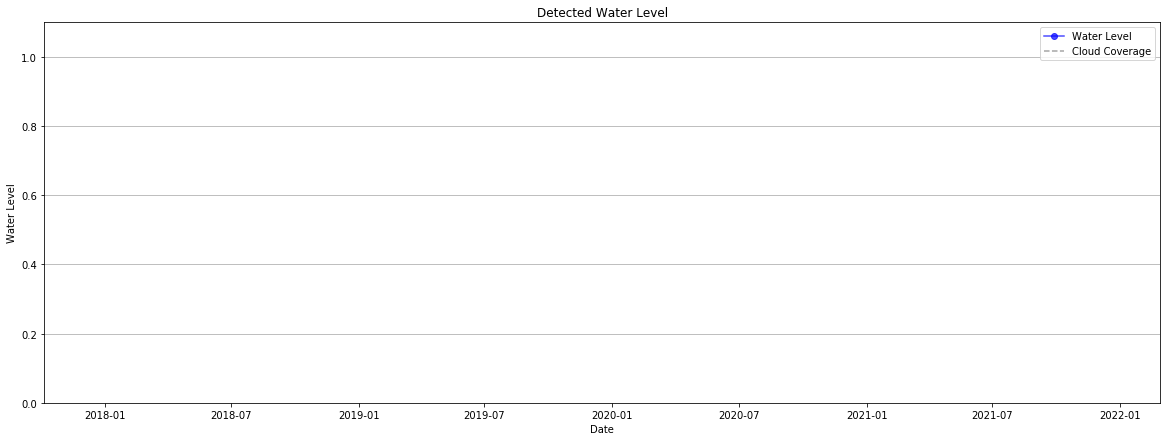

In [18]:
plot_water_levels(eopatch, 0.02);